In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! ls

data  MLProject.ipynb  README.md


In [ ]:
%cd drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn'
/content/drive/MyDrive/Colab Notebooks/MLProject/multi-step-forecasting-rnn


In [ ]:
!git branch

In [ ]:
!git add .

In [ ]:
import pandas as pd
# loading the dataset
day_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/day.csv')
hour_ds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hour.csv')

In [ ]:
hour_ds

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

# preprocessing the data

# extracting day of week
hour_ds['dteday'] = pd.to_datetime(hour_ds['dteday'])
hour_ds['day of week'] = hour_ds['dteday'].dt.dayofweek

# extracting cyclical features using sine and cosine transformations
cyclical_features = ['season', 'mnth', 'weekday', 'hr']
for feature in cyclical_features:
  hour_ds[f'{feature}_sin'] = np.sin(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())
  hour_ds[f'{feature}_cos'] = np.cos(2 * np.pi * hour_ds[feature] / hour_ds[feature].max())

# creating binary variables for time indicators
hour_ds['afternoon'] = np.where((hour_ds['hr'] >= 12) & (hour_ds['hr'] <= 18), 1, 0)
hour_ds['working hour'] = np.where((hour_ds['hr'] >= 9) & (hour_ds['hr'] <= 17), 1, 0)
hour_ds['holiday'] = np.where(hour_ds['holiday'] == 1, 1, 0)
hour_ds['working day'] = np.where(hour_ds['workingday'] == 1, 1, 0)
hour_ds['month start'] = np.where(hour_ds['dteday'].dt.is_month_start, 1, 0)
hour_ds['quarter start'] = np.where(hour_ds['dteday'].dt.is_quarter_start, 1, 0)

# creating lagged values
target = ['cnt', 'casual', 'registered'] # target variables

# lagged (recent)
for feature in target:
  for i in range(1, 4):
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

# lagged (distant)
for feature in target:
  for i in [24, 48, 168]:
    hour_ds[f'{feature}_lag{i}'] = hour_ds[feature].shift(i)

print(hour_ds.shape)
hour_df = hour_ds.dropna()
print(hour_df.shape)

(17379, 49)
(17211, 49)


In [ ]:
hour_df

In [ ]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaled_features = [
    'season_sin',
    'season_cos',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'cnt',
    'casual',
    'registered',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

# Store the original index
original_index = hour_df.index

scaled_df = pd.DataFrame(scaler.fit_transform(hour_df[scaled_features]), columns=scaled_features)

# Reset the index of scaled_df to match the original DataFrame
scaled_df.index = original_index

# Drop the original features using .loc or .iloc
hour_df = hour_df.loc[:, ~hour_df.columns.isin(scaled_features)]

hour_df = pd.concat([hour_df, scaled_df], axis=1)

# selecting relevant features
final_cols = [
    'season_sin',
    'season_cos',
    'day of week',
    'mnth_sin',
    'mnth_cos',
    'weekday_sin',
    'weekday_cos',
    'hr_sin',
    'hr_cos',
    'holiday',
    'afternoon',
    'working hour',
    'working day',
    'month start',
    'quarter start',
    'cnt_lag1',
    'cnt_lag2',
    'cnt_lag3',
    'cnt_lag24',
    'cnt_lag48',
    'cnt_lag168'
]

target = 'cnt'

hour_df_final = hour_df[final_cols + [target]]

print(hour_df_final.shape)
hour_final = hour_df_final.dropna()
print(hour_final.shape)

(17211, 22)
(17211, 22)


In [ ]:
hour_final

In [ ]:
#Previous code

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
y_test = future_test_set[target]

# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

# bootstrap sampling
bootstrap_samples = 50
for _ in range(bootstrap_samples):
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    y_train = train_bs[target]

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    y_val = val_bs[target]

    train_sets.append((train_bs[final_cols], train_bs[target]))
    val_sets.append((val_bs[final_cols], val_bs[target]))

In [ ]:
#Previous Code

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
# references:
# https://towardsdatascience.com/multivariate-timeseries-forecast-with-lead-and-lag-timesteps-using-lstm-1a34915f08a
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# reshape train
X_train_array = X_train.values
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))

# reshape validation
X_val_array = X_val.values
X_val_reshaped = X_val_array.reshape((X_val_array.shape[0], 1, X_val_array.shape[1]))

# building the baseline LSTM model
base_model = Sequential()
base_model.add(LSTM(units=50, input_shape=(1, X_train.shape[1]), dropout=0.5))
# adding a dense layer of a single unit
base_model.add(Dense(units=1))
# using MSE loss function minimized using Adam optimizer
base_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# training
base_model.fit(X_train_reshaped, y_train, epochs=128, batch_size=128, validation_data=(X_val_reshaped, y_val), shuffle=True)



Note to future: We need to calculate confidence intervals and prediction intervals too. Explanation for it is as:

Bootstrapping and RNN Training

Bootstrapping: Instead of using the entire dataset to train a single model, multiple smaller datasets (bootstrap samples) are created by sampling with replacement from the original training dataset.

Separate RNN Training: Each bootstrap sample is used to train a separate RNN model. This results in multiple models, each trained on slightly different data.

Point Prediction: The final prediction for a given point in time (yˆi) is the average of the predictions from all the trained RNN models.

Confidence Intervals

Purpose: Confidence intervals give a range within which we expect the true average (mean) of our predictions to lie. It's not about individual predictions, but about the average accuracy of the model.

Calculation:

Center of Interval: The mean of all model predictions for each point.

Variance Calculation: The variance of the predictions is calculated, giving a measure of how much the predictions differ from the mean.

Confidence Interval: Using the mean and variance, and a value from the t-distribution (for statistical significance), the confidence interval is computed for each point.

Prediction Intervals

Purpose: Prediction intervals are more practical in forecasting. They provide a range within which we expect the actual future values to lie.

More Complex Calculation:

Noise Variance Estimation: This involves computing the variance of the residuals (the differences between actual values and predictions).

Residual Predictor: An additional network is trained to predict these residuals. This network is trained on the validation set.

Total Variance: The variance from the point predictions and the variance from the residual predictions are combined to estimate the total variance for each point.

Prediction Interval: Using this total variance and a value from the t-distribution, prediction intervals are computed for each point.

In [ ]:
#Original Model

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# references: https://carpentries-incubator.github.io/machine-learning-novice-python/07-bootstrapping/index.html

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16
X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
y_test = future_test_set[target]
y_test_adjusted = y_test[15::16]


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
trained_models = []
predictions = []

# Bootstrapping and training loop
bootstrap_samples = 5 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Bootstrap sampling
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    y_train = train_bs[target]
    y_train_adjusted = y_train[15::16]

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    y_val = val_bs[target]
    y_val_adjusted = y_val[15::16]

    # Reshape data for LSTM
    expected_shape_train = (X_train.shape[0] // 16) * 16
    expected_shape_val = (X_val.shape[0] // 16) * 16
    X_train_reshaped = X_train.values[:expected_shape_train].reshape((X_train.shape[0] // 16, 16, X_train.shape[1]))
    X_val_reshaped = X_val.values[:expected_shape_val].reshape((X_val.shape[0] // 16, 16, X_val.shape[1]))

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_reshaped, y_train_adjusted, epochs=128, batch_size=128, validation_data=(X_val_reshaped, y_val_adjusted), shuffle=True)

    # Store the trained model
    trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    model_predictions = model.predict(X_test_reshaped)
    predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals

Epoch 1/128
6/6 [==============================] - 9s 484ms/step - loss: 0.0532 - val_loss: 0.0521
Epoch 2/128
6/6 [==============================] - 0s 59ms/step - loss: 0.0369 - val_loss: 0.0282
Epoch 3/128
6/6 [==============================] - 0s 81ms/step - loss: 0.0317 - val_loss: 0.0257
Epoch 4/128
6/6 [==============================] - 0s 73ms/step - loss: 0.0280 - val_loss: 0.0274
Epoch 5/128
6/6 [==============================] - 0s 67ms/step - loss: 0.0262 - val_loss: 0.0221
Epoch 6/128
6/6 [==============================] - 0s 70ms/step - loss: 0.0246 - val_loss: 0.0191
Epoch 7/128
6/6 [==============================] - 0s 58ms/step - loss: 0.0211 - val_loss: 0.0193
Epoch 8/128
6/6 [==============================] - 0s 46ms/step - loss: 0.0205 - val_loss: 0.0175
Epoch 9/128
6/6 [==============================] - 0s 48ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 10/128
6/6 [==============================] - 0s 49ms/step - loss: 0.0196 - val_loss: 0.0155
Epoch 11/128
6/6 [

In [ ]:

def reshape_with_overlap(X, time_steps, overlap, num_features):
    # Total number of sequences to create
    num_sequences = (X.shape[0] - time_steps) // (time_steps - overlap) + 1

    # Initialize the 3D array for output
    output = np.zeros((num_sequences, time_steps, num_features))

    for i in range(num_sequences):
        start = i * (time_steps - overlap)
        end = start + time_steps
        output[i] = X[start:end]

    return output

In [ ]:
#Model With Batch Overlap

time_steps = 16 # Number of time steps in each batch
overlap = 4 # Number of overlapping points

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16
X_test_reshaped = reshape_with_overlap(X_test.values, time_steps, overlap, X_test.shape[1])
#X_test_reshaped = X_test.values[:expected_shape_test].reshape((X_test.shape[0] // 16, 16, X_test.shape[1]))
y_test = future_test_set[target]
y_test_adjusted = y_test[15::time_steps - overlap]


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
trained_models = []
predictions = []

# Bootstrapping and training loop
bootstrap_samples = 5 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Bootstrap sampling
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    y_train = train_bs[target]
    y_train_adjusted = y_train[15::time_steps - overlap]

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    y_val = val_bs[target]
    y_val_adjusted = y_val[15::time_steps - overlap]

    # Reshape data for LSTM
    expected_shape_train = (X_train.shape[0] // 16) * 16
    expected_shape_val = (X_val.shape[0] // 16) * 16
    X_train_reshaped = reshape_with_overlap(X_train.values, time_steps, overlap, X_train.shape[1])
    #X_train_reshaped = X_train.values[:expected_shape_train].reshape((X_train.shape[0] // 16, 16, X_train.shape[1]))
    X_val_reshaped = reshape_with_overlap(X_val.values, time_steps, overlap, X_val.shape[1])
    #X_val_reshaped = X_val.values[:expected_shape_val].reshape((X_val.shape[0] // 16, 16, X_val.shape[1]))

    # Build a new LSTM model
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(16, X_train.shape[1]), dropout=0.5))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_reshaped, y_train_adjusted, epochs=128, batch_size=128, validation_data=(X_val_reshaped, y_val_adjusted), shuffle=True)

    # Store the trained model
    trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    model_predictions = model.predict(X_test_reshaped)
    predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals

In [ ]:


# evaluation
loss = trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
print(f'Model Loss on Test Set: {loss}')

14/14 [==============================] - 0s 7ms/step - loss: 0.0264
Model Loss on Test Set: 0.026378588750958443


In [ ]:
def extract_sequences(data, sequence_length, num_sequences):
    sequences = []
    for i in range(num_sequences):
        # Check if we can extract a full sequence of the desired length
        if i + sequence_length <= len(data):
            sequence = data[i:i + sequence_length]
            sequences.append(sequence)
        else:
            break  # Break if we reach the end of the data
    return np.array(sequences)

# Extract 100 sequences of 16 time steps
sequence_length = 16
num_sequences = 100
X_test_sequences = extract_sequences(X_test.values, sequence_length, num_sequences)

In [ ]:
# generating one-step predictions for first 100 steps of test set forecasts
def onestep_forecasts(model, X):
  forecasts = []
  for i in range(len(X)):
    sum_of_predictions = 0
    for model_i in range(len(trained_models)):
      forecast_step = model[model_i].predict(X[i].reshape(1, X.shape[1], X.shape[2]))
      sum_of_predictions += forecast_step[0, 0]
    forecasts.append(sum_of_predictions / len(trained_models))

  return np.array(forecasts)

one_step_forecasts = onestep_forecasts(trained_models, X_test_sequences)

In [ ]:
one_step_forecasts

In [ ]:
X_test.columns


Index(['season_sin', 'season_cos', 'day of week', 'mnth_sin', 'mnth_cos',
       'weekday_sin', 'weekday_cos', 'hr_sin', 'hr_cos', 'holiday',
       'afternoon', 'working hour', 'working day', 'month start',
       'quarter start', 'cnt_lag1', 'cnt_lag2', 'cnt_lag3', 'cnt_lag24',
       'cnt_lag48', 'cnt_lag168'],
      dtype='object')

In [ ]:
# generating multi-step forecasts for the first 100 steps of test set forecasts Generates 100 steps only using 16 steps
def multistep_forecasts(model, X, n_steps, X_known):
    forecasts = []
    current_input = X.reshape(1, X.shape[0], X.shape[1])

    for i in range(n_steps):
      sum_of_predictions = 0
      for model_i in range(len(trained_models)):
        forecast_step = model[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step[0, 0]
      forecasts.append(sum_of_predictions / len(trained_models))

      # Update the input for the next time step
      current_input = np.roll(current_input, shift=-1, axis=1)

      #Update new input accordingly
      for k in range(15):
        current_input[0, -1, k] = X_known[i, k]
      current_input[0, -1, 15] = sum_of_predictions / len(trained_models)
      current_input[0, -1, 16] = current_input[0, -2, 15]
      current_input[0, -1, 17] = current_input[0, -2, 16]

      #This part doesn't work too good, better approach may be used---------------------------------------------------
      if i >= 24 and i <  24 + current_input.shape[1]:
        current_input[0, -1, 18] = X[i - 24][15]
        current_input[0, -1, 19] = X[i - 24][18]
      if i >= 48 and i <  48 + current_input.shape[1]:
        current_input[0, -1, 19] = X[i - 48][15]
      if i >= 96 and i <  96 + current_input.shape[1]:
        current_input[0, -1, 20] = X[i - 96][19]


    return np.array(forecasts)

n_steps = 100  # using 16-step unrolled sequences
multi_step_forecasts = multistep_forecasts(trained_models, X_test_reshaped[0], n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 21ms/step


In [ ]:
# generating multi-step forecasts for the first 100 steps of test set forecasts Generates 16 steps at the same time
def multistep_forecasts(model, X, n_steps, X_known):
    forecasts = []
    current_input = X[0].reshape(1, X[0].shape[0], X[0].shape[1])

    for i in range(n_steps):
      if(i % current_input.shape[1] == 0):
        k = i // current_input.shape[1]
        current_input = X[k].reshape(1, X[k].shape[0], X[k].shape[1])
      sum_of_predictions = 0
      for model_i in range(len(trained_models)):
        forecast_step = model[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step[0, 0]
      forecasts.append(sum_of_predictions / len(trained_models))

      # Update the input for the next time step
      current_input = np.roll(current_input, shift=-1, axis=1)

      #Update new input accordingly
      for k in range(15):
        current_input[0, -1, k] = X_known[i, k]
      current_input[0, -1, 15] = sum_of_predictions / len(trained_models)
      current_input[0, -1, 16] = current_input[0, -2, 15]
      current_input[0, -1, 17] = current_input[0, -2, 16]


    return np.array(forecasts)

n_steps = 100  # using 16-step unrolled sequences
multi_step_forecasts = multistep_forecasts(trained_models, X_test_reshaped, n_steps, X_test.values[16:16+n_steps])

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(multi_step_forecasts)

[0.38782921 0.20298398 0.14413527 0.12041455 0.1397074  0.20887328
 0.21534101 0.23825229 0.27348147 0.30630491 0.31274937 0.30525321
 0.30717219 0.3316906  0.38219547 0.3850361  0.24818215 0.29381449
 0.24741898 0.21189676 0.18715941 0.16309536 0.15007813 0.13415452
 0.08888738 0.07829003 0.08041475 0.11816848 0.22912591 0.33655638
 0.25249855 0.23713889 0.0554187  0.19795252 0.23463117 0.24439826
 0.25907969 0.29308089 0.35345947 0.35566006 0.342015   0.29637325
 0.25558563 0.22197318 0.19694508 0.17698806 0.16046359 0.14525916
 0.46946297 0.22447056 0.17466232 0.1808214  0.29626929 0.39463755
 0.26714877 0.21683116 0.21363502 0.22690147 0.23697487 0.2281673
 0.24190104 0.29356079 0.46957313 0.47584086 0.26051285 0.32142287
 0.28447173 0.26675353 0.24432733 0.21028676 0.19118939 0.16856292
 0.11975451 0.10283177 0.10181181 0.14127461 0.26928201 0.36383539
 0.25569121 0.20935127 0.05843768 0.1717441  0.19533325 0.20839772
 0.24242952 0.30973376 0.43240265 0.4252554  0.37436404 0.36138

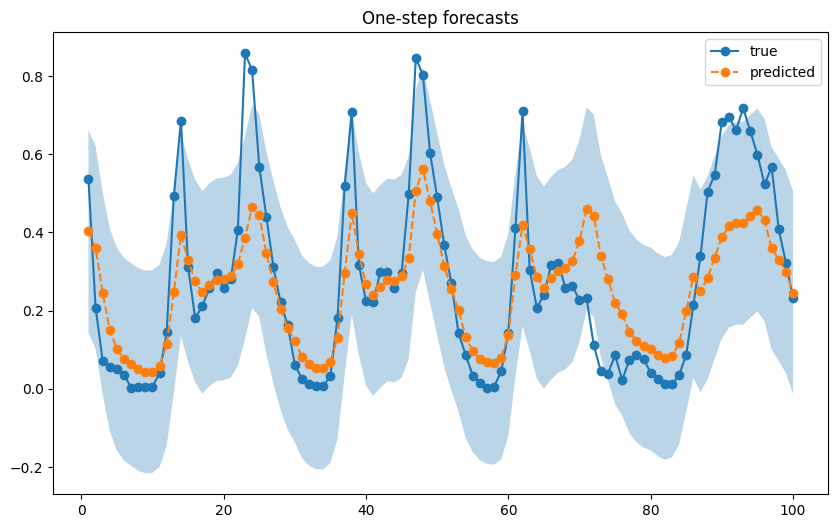

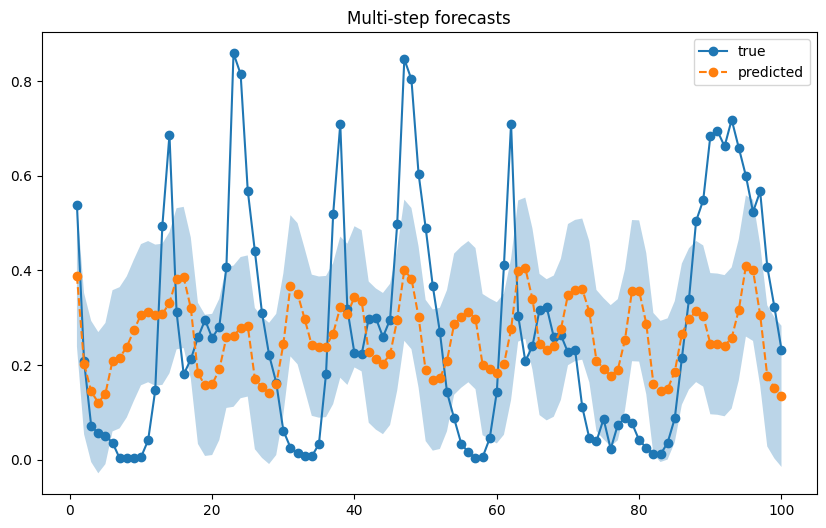

In [ ]:
import matplotlib.pyplot as plt

# plotting true and predicted lines for each set of forecasts

# one-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), one_step_forecasts, label='predicted', marker='o', linestyle='--')
# calculating upper and lower bounds for prediction intervals
plt.fill_between(np.arange(1, 101),
                 one_step_forecasts - 1.96 * np.std(one_step_forecasts),
                 one_step_forecasts + 1.96 * np.std(one_step_forecasts),
                 alpha=0.3)
plt.title('One-step forecasts')
plt.legend()
plt.show()

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
plt.fill_between(np.arange(1, 101),
                 multi_step_forecasts[:100] - 1.96 * np.std(multi_step_forecasts[:100]),
                 multi_step_forecasts[:100] + 1.96 * np.std(multi_step_forecasts[:100]),
                 alpha=0.3)
plt.title('Multi-step forecasts')
plt.legend()
plt.show()

In [ ]:
#Encoder Decoder LSTM Model
#reference https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/#:~:text=Implement%20Encoder%2DDecoder%20LSTMs%20in,encoded%20character%20at%20a%20time.

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.layers import LSTM, RepeatVector
from keras.layers import TimeDistributed, Dense

# splitting the data into train and test (70% and 30%)
split_point = int(len(hour_final) * 0.7)
train_set, future_test_set = train_test_split(hour_final, test_size=0.3, shuffle=False)
X_test = future_test_set[final_cols]
expected_shape_test = (X_test.shape[0] // 16) * 16
X_test_reshaped = X_test.values[:expected_shape_test-16].reshape(((X_test.shape[0] // 16) - 1, 16, X_test.shape[1]))
y_test = future_test_set[target]
y_test_adjusted = y_test.values[15:expected_shape_test - 1].reshape(((y_test.shape[0] // 16) - 1, 16, 1))


# storing training and validation sets during bootstrapping
train_sets = []
val_sets = []

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Initialize lists to store models and their predictions
trained_models = []
predictions = []

# Bootstrapping and training loop
bootstrap_samples = 1 #For test purposes, real value is 50
for i in range(bootstrap_samples):
    # Bootstrap sampling
    train_bs = resample(train_set, replace=True)
    X_train = train_bs[final_cols]
    expected_shape_train = (X_train.shape[0] // 16) * 16
    y_train = train_bs[target]
    y_train_adjusted = y_train.values[15:expected_shape_train - 1].reshape(((y_train.shape[0] // 16) - 1, 16, 1))

    val_bs = train_set.loc[~train_set.index.isin(train_bs.index)]
    X_val = val_bs[final_cols]
    expected_shape_val = (X_val.shape[0] // 16) * 16
    y_val = val_bs[target]
    y_val_adjusted = y_val.values[15:expected_shape_val - 1].reshape(((y_val.shape[0] // 16) - 1, 16, 1))


    # Reshape data for LSTM
    X_train_reshaped = X_train.values[:expected_shape_train - 16].reshape(((X_train.shape[0] // 16) - 1, 16, X_train.shape[1]))
    X_val_reshaped = X_val.values[:expected_shape_val - 16].reshape(((X_val.shape[0] // 16) - 1, 16, X_val.shape[1]))

    # Build an encoder LSTM model
    model = Sequential()
    model.add(LSTM(units=16, input_shape=(16, X_train.shape[1]), dropout=0.5))

    # Build a decoder LSTM model
    model.add(RepeatVector(16))
    model.add(LSTM(units=16, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Train the model
    model.fit(X_train_reshaped, y_train_adjusted, epochs=32, batch_size=4, validation_data=(X_val_reshaped, y_val_adjusted), shuffle=True)

    # Store the trained model
    trained_models.append(model)

    # Evaluate the model on the test set and store predictions
    # Note: Replace X_test_reshaped and y_test with your actual test data reshaped accordingly

    model_predictions = model.predict(X_test_reshaped)
    predictions.append(model_predictions)

    print("Finished sample " + str(i+1))

# You can now use the stored predictions to calculate prediction intervals

Epoch 1/32
188/188 [==============================] - 13s 29ms/step - loss: 0.0274 - val_loss: 0.0242
Epoch 2/32
188/188 [==============================] - 3s 18ms/step - loss: 0.0253 - val_loss: 0.0236
Epoch 3/32
188/188 [==============================] - 3s 18ms/step - loss: 0.0252 - val_loss: 0.0245
Epoch 4/32
188/188 [==============================] - 4s 24ms/step - loss: 0.0250 - val_loss: 0.0236
Epoch 5/32
188/188 [==============================] - 5s 26ms/step - loss: 0.0248 - val_loss: 0.0231
Epoch 6/32
188/188 [==============================] - 3s 18ms/step - loss: 0.0244 - val_loss: 0.0234
Epoch 7/32
188/188 [==============================] - 3s 18ms/step - loss: 0.0246 - val_loss: 0.0222
Epoch 8/32
188/188 [==============================] - 4s 21ms/step - loss: 0.0243 - val_loss: 0.0228
Epoch 9/32
188/188 [==============================] - 5s 27ms/step - loss: 0.0242 - val_loss: 0.0224
Epoch 10/32
188/188 [==============================] - 4s 19ms/step - loss: 0.0244 - val_l

In [ ]:
y_test_adjusted[:6]

array([[[0.53790984],
        [0.2079918 ],
        [0.07172131],
        [0.05532787],
        [0.05020492],
        [0.03586066],
        [0.00307377],
        [0.00409836],
        [0.00409836],
        [0.00512295],
        [0.04098361],
        [0.14651639],
        [0.49385246],
        [0.68647541],
        [0.31147541],
        [0.18032787]],

       [[0.21209016],
        [0.25819672],
        [0.29508197],
        [0.25717213],
        [0.2807377 ],
        [0.4067623 ],
        [0.85860656],
        [0.81454918],
        [0.56864754],
        [0.44057377],
        [0.31045082],
        [0.22131148],
        [0.16290984],
        [0.06147541],
        [0.02561475],
        [0.01331967]],

       [[0.00717213],
        [0.00717213],
        [0.03278689],
        [0.18135246],
        [0.51844262],
        [0.70901639],
        [0.31762295],
        [0.22438525],
        [0.22233607],
        [0.29815574],
        [0.29918033],
        [0.25922131],
        [0.29610656],
      

In [ ]:

# evaluation
loss = trained_models[0].evaluate(X_test_reshaped, y_test_adjusted)
print(f'Model Loss on Test Set: {loss}')

11/11 [==============================] - 0s 9ms/step - loss: 0.0568
Model Loss on Test Set: 0.05680831894278526


In [ ]:
forecast_step = trained_models[0].predict(X_test_reshaped[0].reshape(1, X_test_reshaped[0].shape[0], X_test_reshaped[0].shape[1]))


1/1 [==============================] - 0s 49ms/step


In [ ]:
forecast_step.shape

(1, 16, 48)

In [ ]:
# generating multi-step forecasts for the first 100 steps of test set forecasts
def multistep_forecasts_ed(model, X, n_steps):
    current_step = 0
    forecasts = []
    for i in range(n_steps):
      if current_step > n_steps:
        break
      current_input = X[i].reshape(1, X[i].shape[0], X[i].shape[1])
      sum_of_predictions = np.zeros((current_input.shape[1]))
      for model_i in range(len(model)):
        forecast_step = model[model_i].predict(current_input.reshape(1, current_input.shape[1], current_input.shape[2]))
        sum_of_predictions += forecast_step.reshape(-1)
      forecasts = np.append(forecasts, sum_of_predictions / len(model))
      current_step += current_input.shape[1]
    return np.array(forecasts)

n_steps = 100  # using 16-step unrolled sequences
multi_step_forecasts = multistep_forecasts_ed(trained_models, X_test_reshaped, n_steps)

1/1 [==============================] - 0s 67ms/step


In [ ]:
multi_step_forecasts

array([0.4857344 , 0.16337024, 0.18599267, 0.18129575, 0.16204596,
       0.16674942, 0.16458148, 0.16373923, 0.16412246, 0.16375147,
       0.1636989 , 0.16364281, 0.16355067, 0.16350271, 0.16345368,
       0.16341378, 0.31039268, 0.15168144, 0.16035075, 0.1773895 ,
       0.16832626, 0.16862702, 0.17014742, 0.16973811, 0.1698083 ,
       0.16996099, 0.16995612, 0.16996627, 0.16997878, 0.16997811,
       0.1699772 , 0.16997655, 0.05340257, 0.18110213, 0.17219175,
       0.1609813 , 0.16919211, 0.16968234, 0.16915923, 0.16966817,
       0.16978836, 0.16978125, 0.16981609, 0.16983192, 0.16983657,
       0.16984197, 0.169846  , 0.16984873, 0.52996254, 0.16768676,
       0.20463318, 0.18153229, 0.16414709, 0.16836607, 0.16380319,
       0.16341677, 0.16325381, 0.16261959, 0.16253057, 0.16232002,
       0.16216892, 0.16206859, 0.16197056, 0.16189951, 0.32905656,
       0.14685883, 0.16143636, 0.17602488, 0.16500627, 0.16669306,
       0.16786413, 0.16726175, 0.1675005 , 0.16761509, 0.16759

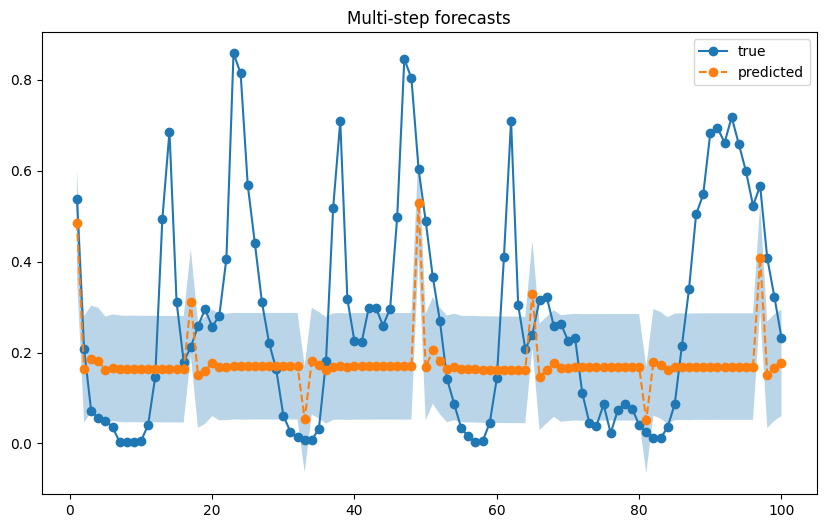

In [ ]:
import matplotlib.pyplot as plt

# plotting true and predicted lines for each set of forecasts

# multi-step
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 101), y_test[sequence_length - 1 :num_sequences + sequence_length - 1], label='true', marker='o', linestyle='-')
plt.plot(np.arange(1, 101), multi_step_forecasts[:100], label='predicted', marker='o', linestyle='--')
plt.fill_between(np.arange(1, 101),
                 multi_step_forecasts[:100] - 1.96 * np.std(multi_step_forecasts[:100]),
                 multi_step_forecasts[:100] + 1.96 * np.std(multi_step_forecasts[:100]),
                 alpha=0.3)
plt.title('Multi-step forecasts')
plt.legend()
plt.show()